In [1]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image

In [19]:
def non_max_suppression_slow(boxes, overlapThresh):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []
 
    # initialize the list of picked indexes
    # 抑制されたboundingboxを格納する
    pick = []
 
    # grab the coordinates of the bounding boxes
    # 引数の boundingboxes から startX,startY,endX,endY をスライシングして取得
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]
    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    # 各boundingboxの面積を計算する
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    # endYを昇順でソートし、ソート時のインデックスを取得する
    idxs = np.argsort(y2)
    # keep looping while some indexes still remain in the indexes
    # list
    # インデックスリストが空になるまでループする
    while len(idxs) > 0:
        # grab the last index in the indexes list, add the index
        # value to the list of picked indexes, then initialize
        # the suppression list (i.e. indexes that will be deleted)
        # using the last index
        # 現在のインデックスの長さを取得
        last = len(idxs) - 1
        # 現在のインデックスリストからの後ろ(bboxの右下座標が最も大きいもの)のインデックスを取得する
        i = idxs[last]
        # pickリストにインデックスを追加
        pick.append(i)
        # 現在のインデックスの長さを格納
        suppress = [last]
        
        # インデックスの中身を全て見る、overlapの値を計算する
        for pos in range(0,last):
            # ループ時のインデックスを取得
            j = idxs[pos]
            
            # 重複した部分の startX, startY, endX, endY を取得する
            xx1 = max(x1[i],x1[j])
            yy1 = max(y1[i],y1[j])
            xx2 = min(x2[i],x2[j])
            yy2 = min(y2[i],y2[j])    
            
            # 重複部分の幅と高さを計算
            w = max(0,xx2 - xx1 +1)
            h = max(0, yy2 - yy2 + 1)
            
            # overlap値を求めるため、重複部分の面積をとループ時のbounding box の面積で割る
            overlap = 100*float(w * h) / area[j]
            print(overlap)
            # もし求めたoverlap値が引数のしきい値より大きい = 重複していれば抑制、削除するためのリストに追加する
            if(overlap > overlapThresh and overlap < 3):
                suppress.append(pos)
        
        # 抑制するboundingboxのインデックスを削除する
        idxs = np.delete(idxs,suppress)
    # 残ったbounding boxの座標リストを返す
    return boxes[pick]

In [3]:
# AlexNet

X = tf.placeholder(tf.float32, shape=[None, 224*224*3],name="input")
t = tf.placeholder(tf.float32, shape=[None, 4])
keep_prob = tf.placeholder(tf.float32,name="keep_prob")
### 入力層
input_layer = tf.reshape(X, [-1,224,224,3])

### 畳込み層、プーリング層1
h_conv1 = tf.layers.conv2d(inputs=input_layer,filters=96,kernel_size=[11, 11],strides=(4,4),padding='same',activation=tf.nn.relu)
h_norm1 = tf.nn.local_response_normalization(h_conv1,depth_radius=2,alpha=2e-5,beta=0.75)
h_pool1 = tf.layers.max_pooling2d(inputs=h_norm1,pool_size=(3,3),strides=(2,2),padding='same')

### 畳込み層、プーリング層2
h_conv2 = tf.layers.conv2d(inputs=h_pool1,filters=256,kernel_size=[5, 5],padding='same',activation=tf.nn.relu)
h_norm2 = tf.nn.local_response_normalization(h_conv2,depth_radius=2,alpha=2e-5,beta=0.75)
h_pool2 = tf.layers.max_pooling2d(inputs=h_norm2,pool_size=(3,3),strides=(2,2),padding='same')

### 畳込み層、プーリング層3
h_conv3_1 = tf.layers.conv2d(inputs=h_pool2,filters=384,kernel_size=[3, 3],padding='same',activation=tf.nn.relu)
h_conv3_2 = tf.layers.conv2d(inputs=h_conv3_1,filters=384,kernel_size=[3, 3],padding='same',activation=tf.nn.relu)
h_conv3_3 = tf.layers.conv2d(inputs=h_conv3_2,filters=256,kernel_size=[3, 3],padding='same',activation=tf.nn.relu)

h_pool3 = tf.layers.max_pooling2d(inputs=h_conv3_3,pool_size=(3,3),strides=(2,2),padding='same')

### 全結合層1

stddev = np.sqrt(1.0 / 7*7*256)
h_W_fc1 = tf.Variable(tf.truncated_normal([7*7*256,4096], stddev=stddev)) 
h_b_fc1 = tf.Variable(tf.constant(0.1, shape=[4096]))
h_pool3_flat = tf.reshape(h_pool3, [-1, 7*7*256])
h_fc1 = tf.nn.relu(tf.matmul(h_pool3_flat, h_W_fc1) + h_b_fc1)

h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

### 全結合層2

stddev = np.sqrt(1.0 / 4096)
h_W_fc2 = tf.Variable(tf.truncated_normal([4096,4096], stddev=stddev)) 
h_b_fc2 = tf.Variable(tf.constant(0.1, shape=[4096]))
h_fc2 = tf.nn.relu(tf.matmul(h_fc1_drop, h_W_fc2) + h_b_fc2)

h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob)

### 出力層
stddev = np.sqrt(2.0 / 4096)
W_fc3 = tf.Variable(tf.truncated_normal([4096,4], stddev=stddev))
b_fc3 = tf.Variable(tf.constant(0.1, shape=[4]))
fc = tf.nn.xw_plus_b(h_fc2_drop,W_fc3,b_fc3,name="output")
y_conv = tf.nn.softmax(fc,name="output2")

### 損失
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=t, logits=y_conv))

### 学習op
optimizer = tf.train.AdamOptimizer(1e-6)
train_step = optimizer.minimize(loss)

### モデルの評価
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(t,1))
# 精度
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [4]:
saver = tf.train.Saver()

sess = tf.Session()
sess.run(tf.global_variables_initializer())
ckpt = tf.train.get_checkpoint_state('./RoadSign-Alexnet-ckpt')
if ckpt:
  # checkpointファイルから最後に保存したモデルへのパスを取得する
  last_model = ckpt.model_checkpoint_path
  print("load {0}".format(last_model))
  # 学習済みモデルを読み込む
  saver.restore(sess, last_model)

load ./RoadSign-Alexnet-ckpt/roadsign_alex
INFO:tensorflow:Restoring parameters from ./RoadSign-Alexnet-ckpt/roadsign_alex


In [28]:
def template_matching(target_gray_img,target_img):
  # 止まれと制限速度20の画像でマッチングを行う
  # 40x40 のサイズでテンプレートマッチングする
  template_image1 = cv2.imread("./train_dataset/limitspeed-00053.jpg",0)
  template_image2 = cv2.imread("./train_dataset/stop-00054.jpg",0)
  template_image1 = cv2.resize(template_image1,(40,40))
  template_image2 = cv2.resize(template_image2,(40,40))

  template_images = [template_image1,template_image2]
  w, h = template_image1.shape[::-1]
  
  bboxes = []
  region_images = []

  for tmp_img in template_images:
    res = cv2.matchTemplate(target_gray_img,tmp_img,cv2.TM_CCOEFF_NORMED)
    threshold = 0.5
    loc = np.where( res >= threshold)
    tmp_bboxes = []
    # マッチングした(x,y)座標を格納
    for pt in zip(*loc[::-1]):
        tmp_bboxes.append(np.array([pt[0],pt[1],pt[0]+w,pt[1]+h]))

    # 非最大抑制をして重複を消す
    pick = non_max_suppression_slow(np.array(tmp_bboxes),0.3) 
    bboxes.extend(pick)

    # 領域を 224x224 のサイズで切り抜き
    # 配列を opencv -> PIL に変換
    for startX,startY,endX,endY in pick:
        tmp = target_img[startY:endY,startX:endX]
        resize_img = cv2.resize(tmp, (224,224))
        t = np.asarray(resize_img)
        t = t[:, :, ::-1]
        PIL_data = Image.fromarray(t)
        pil_array = np.frombuffer(np.array(PIL_data),dtype=np.uint8)
        region_images.append(pil_array)
        
  return region_images,bboxes

In [34]:
def predict_fromRegionProposal(orig_img,images,bboxes):
  # 候補領域から画像認識を行う
  tmp_bboxes = []
  ret_bboxes = []
  for i in range(0,len(bboxes)):
    startX,startY,endX,endY = bboxes[i]
    img = images[i]
    img = img.astype(np.float32)
    img /= 255.0
    ans = sess.run(fc,feed_dict={X:np.array(img).reshape(-1,224*224*3),keep_prob:1.0})
    print(ans)
    p = np.argmax(ans,axis=1)
    if(ans[:,p] > 0.6):
      tmp_bboxes.append(np.array([p,startX,startY,endX,endY]))
      if(p == 0):
        cv2.rectangle(orig_img,(startX,startY),(endX,endY),(255,0,0),1)
      elif(p == 1):
        cv2.rectangle(orig_img,(startX,startY),(endX,endY),(0,255,0),1)
      elif(p == 2):
        cv2.rectangle(orig_img,(startX,startY),(endX,endY),(0,0,255),1)
      elif(p == 3):
        cv2.rectangle(orig_img,(startX,startY),(endX,endY),(30,10,30),1)

  return tmp_bboxes

In [56]:
# ターゲット画像
target_image = cv2.imread("./R-CNN_images/testimage2.jpg")
target_image = cv2.resize(target_image,(224,224))
target_gray = cv2.cvtColor(target_image, cv2.COLOR_BGR2GRAY)
target_out_image = target_image.copy()
target_tmp_image = target_image.copy()

In [ ]:
# テンプレートマッチングを行う
region_images,bboxes = template_matching(target_gray_img=target_gray,target_img=target_image)

In [58]:
# 候補領域をCNNにかける
ret_bboxes = predict_fromRegionProposal(target_out_image,region_images,bboxes)

[ 40  68  80 108]
[[ -5.81246233   1.76443267  11.68881702   6.74102306]]
[ 38  90  78 130]
[[  7.44181681  -0.86355162  -2.83137465  10.10734749]]


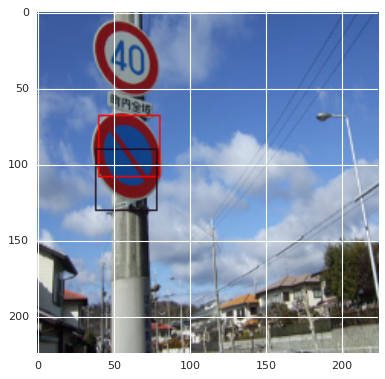

In [59]:
plt.imshow(cv2.cvtColor(target_out_image, cv2.COLOR_BGR2RGB))